In [1]:
# testing performance evaluation


from typing import List

import torch

from ddpgportfolio.agent.ddpg_agent import DDPGAgent
from ddpgportfolio.dataset import KrakenDataSet
from ddpgportfolio.portfolio.portfolio import Portfolio

torch.set_default_device("mps")



BATCH_SIZE = 50  # training is done in mini-batches
WINDOW_SIZE = 50  # last n timesteps for the price tensor
STEP_SIZE = 1  # for rolling window batch sampler
start_date = "2024-01-01"  # start date of trading
# DEVICE = "mps"

asset_names: List[str] = [
    "CASH",
    "SOL",
    "ADA",
    "USDT",
    "AVAX",
    "LINK",
    "DOT",
    "PEPE",
    "ETH",
    "XRP",
    "TRX",
    "MATIC",
]

portfolio = Portfolio(asset_names=asset_names, start_date=start_date)

agent = DDPGAgent(portfolio, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, 100)

# need to pretrain the agent to populate the replay buffer with experiences
agent.pre_train()





pre-training ddpg agent started...
ReplayMemoryBuffer populating with experience...
pretraining done
buffer size: 13071


Training Started for DDPG Agent
Episode 1 - Actor Loss: -0.0648, Critic Loss: 0.9947, Total Reward: 53.8333
Episode 2 - Actor Loss: -0.0712, Critic Loss: 0.9368, Total Reward: 122.6164
Episode 3 - Actor Loss: -0.0860, Critic Loss: 0.8591, Total Reward: 102.0478
Episode 4 - Actor Loss: -0.0981, Critic Loss: 0.8144, Total Reward: 133.7414
Episode 5 - Actor Loss: -0.1106, Critic Loss: 0.8279, Total Reward: 125.9024
Episode 6 - Actor Loss: -0.1158, Critic Loss: 0.9316, Total Reward: 52.2610
Episode 7 - Actor Loss: -0.1186, Critic Loss: 0.7450, Total Reward: 153.5125
Episode 8 - Actor Loss: -0.1301, Critic Loss: 0.7674, Total Reward: 175.8990
Episode 9 - Actor Loss: -0.1430, Critic Loss: 0.9036, Total Reward: 171.4638
Episode 10 - Actor Loss: -0.1582, Critic Loss: 0.8017, Total Reward: 170.3476
Episode 11 - Actor Loss: -0.1647, Critic Loss: 0.9063, Total Reward: 108.2855
Episode 12 - Actor Loss: -0.1645, Critic Loss: 0.8230, Total Reward: 105.1573
Episode 13 - Actor Loss: -0.1674, Critic Lo

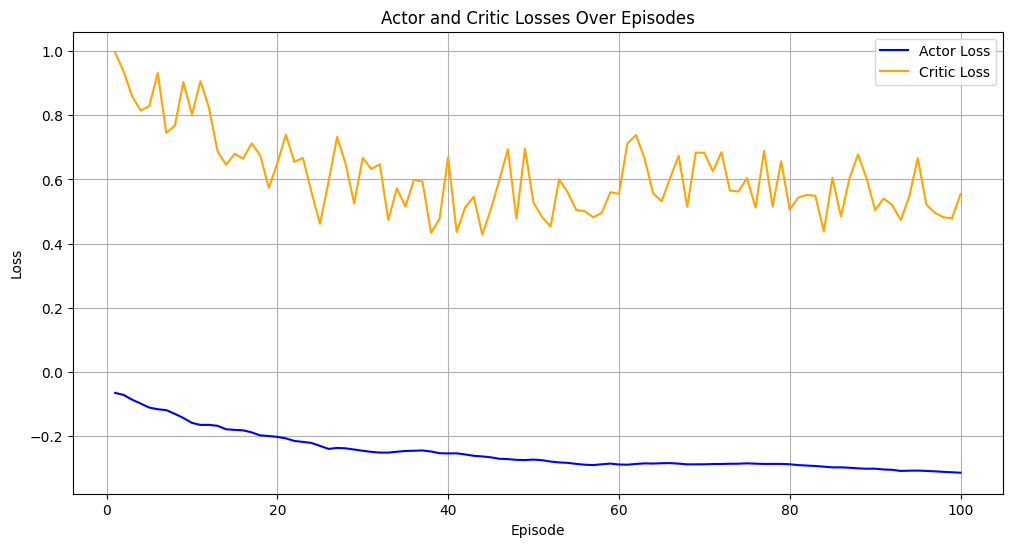

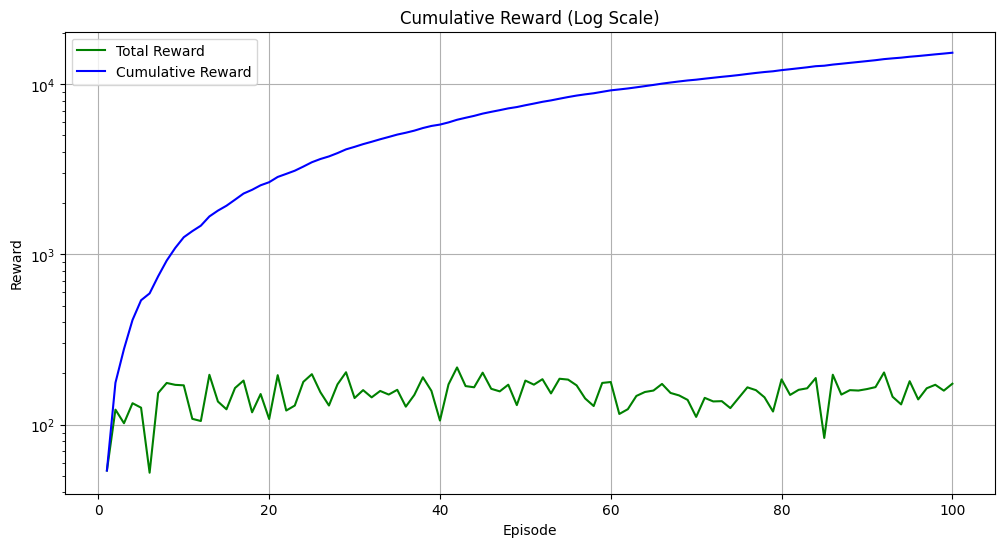

In [2]:
agent.train(100);

In [ ]:
from utilities.pg_utils import plot_equity_curve

In [3]:
import numpy as np
weights = []
ds = KrakenDataSet(portfolio, 50, 1)

In [4]:


pf_previous = 10000
agent_equity_curve = [pf_previous]
total_reward = 0
weights = []

for i in range(len(ds) + 48):
    Xt, prev_index = ds[i]
    yt = 1 / Xt[0, :, -2]
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    #wt_prev = agent.pvm.get_memory_stack(prev_index)
    wt = agent.pvm.get_memory_stack(prev_index + 1)
    wt_cash = 1 - wt.sum()
    wt = torch.concat([wt_cash.unsqueeze(0), wt], dim=-1)
    weights.append(wt)
    #reward = portfolio.get_reward(wt, yt, wt_prev)
    reward = torch.dot(wt, yt) 
    pf_current = pf_previous * reward
    agent_equity_curve.append(pf_current.item())
    pf_previous = pf_current
    

In [ ]:
len(agent_equity_curve)

In [5]:
cl_price = portfolio.get_close_price()
dates = cl_price.index

In [6]:
def calculate_total_return(equity_curve):
    """
    Calculate the total return from an equity curve.

    Args:
        equity_curve (list): List of portfolio values over time.

    Returns:
        float: Total return as a percentage.
    """
    V_start = equity_curve[0]
    V_end = equity_curve[-1]
    total_return = ((V_end - V_start) / V_start) * 100
    return total_return


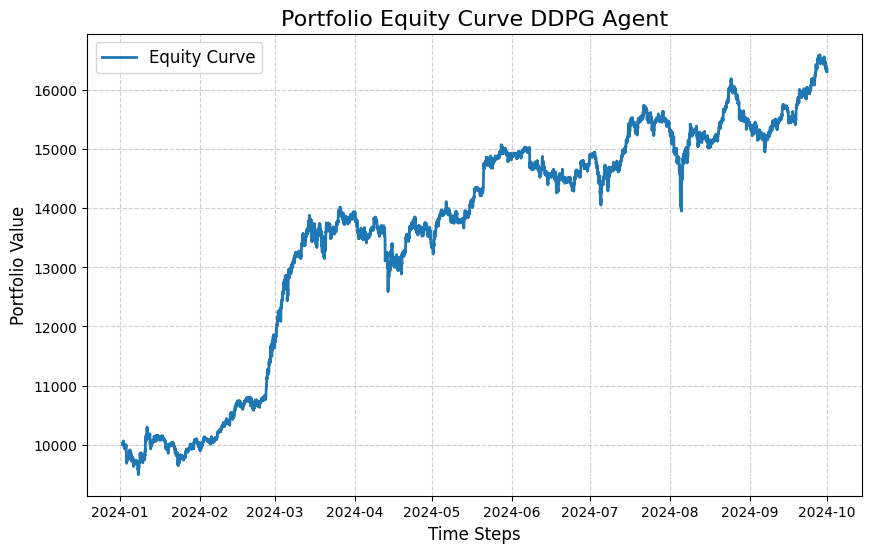

In [14]:
import matplotlib.pyplot as plt

#smoothed_equity = np.convolve(portfolio_values, np.ones(5)/5, mode='valid')
#equity_curve = portfolio_values[1:]
# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(dates[50:], agent_equity_curve, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve DDPG Agent", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [10]:
calculate_total_return(agent_equity_curve)

63.10646484375

In [8]:
weights[-10:]

[tensor([0.6862, 0.0287, 0.0281, 0.0304, 0.0284, 0.0281, 0.0274, 0.0272, 0.0288,
         0.0283, 0.0306, 0.0277], device='mps:0'),
 tensor([0.6854, 0.0287, 0.0283, 0.0298, 0.0286, 0.0281, 0.0276, 0.0285, 0.0286,
         0.0283, 0.0302, 0.0277], device='mps:0'),
 tensor([0.6702, 0.0300, 0.0296, 0.0310, 0.0299, 0.0298, 0.0292, 0.0299, 0.0300,
         0.0298, 0.0314, 0.0291], device='mps:0'),
 tensor([0.6827, 0.0292, 0.0285, 0.0297, 0.0283, 0.0287, 0.0279, 0.0290, 0.0290,
         0.0285, 0.0302, 0.0282], device='mps:0'),
 tensor([0.6443, 0.0331, 0.0318, 0.0328, 0.0322, 0.0322, 0.0312, 0.0337, 0.0326,
         0.0312, 0.0332, 0.0316], device='mps:0'),
 tensor([0.6761, 0.0304, 0.0288, 0.0295, 0.0297, 0.0294, 0.0283, 0.0311, 0.0296,
         0.0285, 0.0301, 0.0285], device='mps:0'),
 tensor([0.6807, 0.0298, 0.0287, 0.0290, 0.0292, 0.0291, 0.0280, 0.0298, 0.0292,
         0.0285, 0.0296, 0.0283], device='mps:0'),
 tensor([0.6669, 0.0308, 0.0303, 0.0305, 0.0303, 0.0302, 0.0294, 0.0305, 0.0

In [ ]:
for t, wt in enumerate(weights[:20]):
    print(f"Episode {t}: Weights = {wt}")

In [11]:
buy_and_hold_weights = np.ones(12) / 12 # Equal allocation
buy_and_hold_equity = [10000]
pf_previous = 10000

for i in range(len(ds) + 48):
    Xt, _ = ds[i]
    yt = 1 / Xt[0, :, -2] # Price relatives
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    reward = np.dot(buy_and_hold_weights, yt.cpu().numpy())  # No rebalancing
    pf_current = pf_previous * reward
    buy_and_hold_equity.append(pf_current)
    pf_previous = pf_current

In [ ]:
buy_and_hold_weights

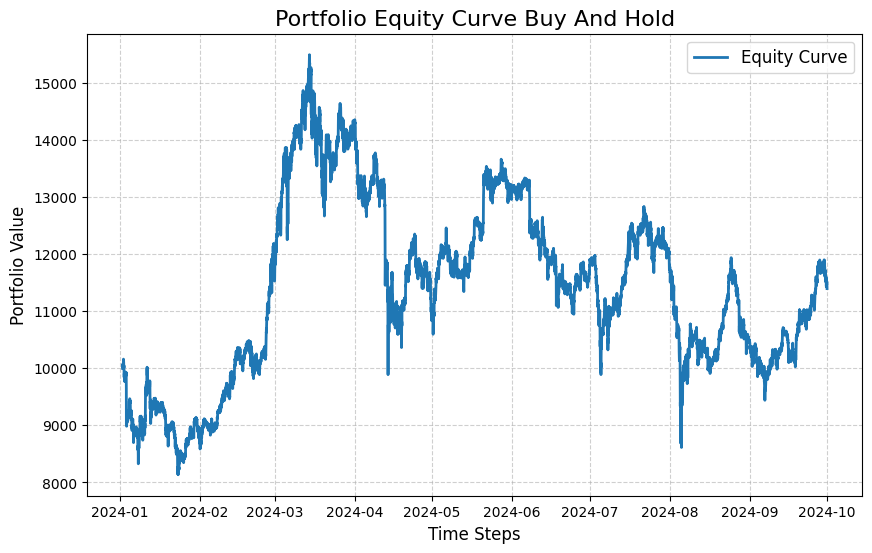

In [13]:
import matplotlib.pyplot as plt
cl_price = portfolio.get_close_price()
dates = cl_price.index
plt.figure(figsize=(10, 6))
plt.plot(dates[50:], buy_and_hold_equity, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve Buy And Hold", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [ ]:
calculate_total_return(buy_and_hold_equity)

In [ ]:
plt.bar(cl_price.columns[1:], wt.cpu().numpy())

In [ ]:
cl_price.columns

In [ ]:
cl_price['MATIC'].plot()